# Aprendizaje supervisado en redes multicapa


date: 11/02/2025  
File: practica_4_ej_1_y_2.ipynb  
Author : Pablo Naim Chehade   
Email: pablo.chehade.villalba@gmail.com  
GitHub: https://github.com/Lupama2  



Emplearemos la siguiente Red Neuronal para aprender la regla XOR. La regla XOR tiene dos entradas (+1 o -1) y la salida es -1 si ambas son diferentes y +1 si ambas son iguales. La red neuronal tiene dos neuronas en la capa de entrada, dos neuronas en la capa oculta y una neurona en la capa de salida. Además, se añaden dos unidades de entrada adicional para simular los umbrales (bias). Como fuinción de activación se emplea la tangente hiperbólica.

Para medir el desempeño de la arquitectura se crean N_CI redes idénticas. Cada una de ellas es entrenada y se reporta el error cuadrático medio (MSE) en el conjunto de entrenamiento. Se calcula el promedio y la desviación estándar de los errores cuadráticos medios.

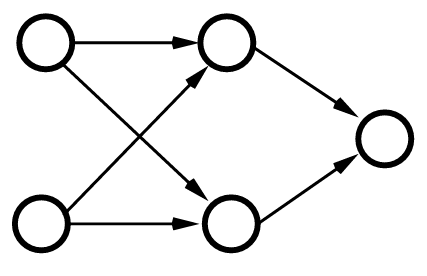

### Importo dependencias

In [2]:
#Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#Hago los gráficos interactivos
# %matplotlib ipympl

#Fuente y tamaño de los caracteres en los gráficos
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 17}
matplotlib.rc('font', **font)

### Defino datos

In [3]:
#Def regla XOR
def XOR(x1, x2):
    #x1, x2: +1 o -1
    if x1 == x2:
        return 1
    else:
        return -1

#Def datos x e y
x_data = np.empty([4, 2])
y_data = np.empty(4)

x_data[0] = np.array([1,1])
x_data[1] = np.array([1,-1])
x_data[2] = np.array([-1,1])
x_data[3] = np.array([-1,-1])

for i in range(len(y_data)):
    y_data[i] = XOR(x_data[i][0], x_data[i][1])


### Defino funciones

In [4]:
#Def la aplicación de una red
def red_forward(x_test, red):
    V_0 = np.concatenate((x_test, np.array([-1])), axis = 0) #Agrego el bias 3x1
    for j in range(len(red["pesos"])):
        w = red["pesos"][j]
        h = np.dot(w.T, V_0)
        if j != len(red["pesos"]) - 1:
            V_1 = np.concatenate((g(h), np.array([-1])), axis = 0) #3x1
        else: #Si estoy en la última capa
            V_1 = g(h)
        V_0 = V_1
    return V_1[0]

#Def función de validación
def validacion(x_test, y_test, red):
    error = 0

    for i in range(len(y_test)):
        #Forward pass
        y_out = red_forward(x_test[i], red)

        #Aproximo y_out para que sea +1 o -1
        if y_out >= 0:
            y_out = 1
        else:
            y_out = -1

        #Calculo el error
        error += np.abs(y_test[i] - np.round(y_out))/2 #Da 0 si no hay error y 1 si hay error


    return error/len(y_test)

def e_loss(x_test, y_test, red):
    error = 0

    for i in range(len(y_test)):
        #Forward pass
        y_out = red_forward(x_test[i], red)
        #Calculo el error
        error += (y_test[i] - y_out)**2

    return error/2

#Def función de transferencia
def g(h_vec):
    return np.tanh(h_vec)

def g_prima(h_vec):
    return 1 - g(h_vec)**2

### Def redes

### Back-propagation

In [5]:

#Def algoritmo de retropropagación de errores
def back_propagation(x_data, y_data, red, eta):
    #Se usa la nomenclatura del Hertz

    #Loop sobre las muestras
    for i in range(len(y_data)):   
        #Forward pass
        V_0 = np.concatenate((x_data[i], np.array([-1])), axis = 0) #Agrego el bias 3x1
        w_1 = red["pesos"][0] #3x2
        
        h_1 = np.dot(w_1.T, V_0) #2x1
        V_1 = np.concatenate((g(h_1), np.array([-1])), axis = 0) #3x1

        w_2 = red["pesos"][1] #3x1
        h_2 = np.dot(w_2.T, V_1) #1x1
        V_2 = g(h_2) #1x1

        #Backward
        #Calculo el error de la capa de salida
        delta_2 = g_prima(h_2)*(y_data[i] - V_2) #1x1

        #Calculo el error de la capa oculta
        # delta_1 = g_prima(h_1)*np.dot(w_2, delta_2) #
        delta_1 = np.concatenate([g_prima(h_1),np.array([1])])*np.dot(w_2, delta_2) #3x1

        #Actualizo pesos
        w_1 += eta * np.outer(V_0, delta_1[:-1]) #3x2
        w_2 += eta * np.outer(V_1, delta_2)
        if red["name"] == "B":
            #Tengo que fijar algunos elementos de los pesos para que no varíen
            w_1[0,0] = 1; w_1[0,2] = 0
            w_1[1,0] = 0; w_1[1,2] = 1
            w_1[2,0] = 0; w_1[2,2] = 0
        
        red["pesos"] = [w_1, w_2]

    return red

#Def algoritmo de aprendizaje
def aprendizaje(x_data, y_data, red, eta, epochs = 1):
    #Def array de errores
    e_loss_vec = np.empty(epochs)
    validacion_vec = np.empty(epochs)

    #Loop sobre las epochs
    for i in range(epochs):
        #Backpropagation
        red = back_propagation(x_data, y_data, red, eta)
        
        #Cálculo de errores
        e_loss_vec[i] = e_loss(x_data, y_data, red)
        validacion_vec[i] = validacion(x_data, y_data, red)


    return red, e_loss_vec, validacion_vec


### Aprendizaje

Para cada arquitectura repito el entrenamiento con 10 condiciones iniciales distintas

In [6]:
np.random.seed(1) #def seed

In [7]:

N_CI = 10 #Nro de condiciones iniciales
N_epochs = 2000 #nro de epochs que voy a entrenar

def red_A(w_ini_max):
    #Cambia en cada llamada por los nros random
    return {"name": "A", "input":2, "hidden":2, "output":1, "pesos":[np.random.rand(3,2)*w_ini_max, np.random.rand(3,1)*w_ini_max]}


def aprendizaje_redes(N_CI, N_epochs, red, x_data, y_data, eta = 0.1):
    #red escrita como función, de modo de que cambie los pesos en cada CI

    w_ini_max = 1 #peso máximo en la inicialización

    e_loss_matrix = np.empty([N_CI, N_epochs])
    validation_matrix = np.empty([N_CI, N_epochs])

    for i in range(N_CI):

        #Entreno red
        model_A = aprendizaje(x_data, y_data, red(w_ini_max), eta, epochs = N_epochs)

        #Guardo el error
        e_loss_matrix[i] = model_A[1]
        validation_matrix[i] = model_A[2]

    #Calculo media y desviación estándar de la media de los errores a cada tiempo
    e_loss_mean = np.mean(e_loss_matrix, axis = 0)
    e_loss_std = np.std(e_loss_matrix, axis = 0)/np.sqrt(N_CI)
    validation_mean = np.mean(validation_matrix, axis = 0)
    validation_std = np.std(validation_matrix, axis = 0)/np.sqrt(N_CI)

    red_final = model_A[0]

    return e_loss_mean, e_loss_std, validation_mean, validation_std, red_final

A_e_loss_mean, A_e_loss_std, A_validation_mean, A_validation_std, A_red_final = aprendizaje_redes(N_CI, N_epochs, red_A, x_data, y_data)


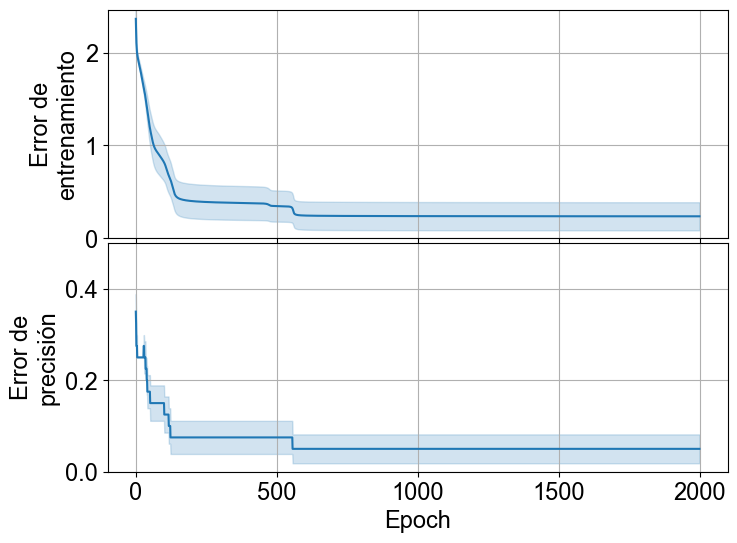

In [11]:
#Grafico

fig, ax = plt.subplots(2, 1, figsize = (8,6), sharex=True)
fig.subplots_adjust(hspace=0.02)

#Red A:
ax[0].plot(A_e_loss_mean, color = "tab:blue")
ax[0].fill_between(np.arange(N_epochs), A_e_loss_mean - A_e_loss_std, A_e_loss_mean + A_e_loss_std, alpha = 0.2, color = "tab:blue")
ax[1].plot(A_validation_mean, color = "tab:blue")
ax[1].fill_between(np.arange(N_epochs), A_validation_mean - A_validation_std, A_validation_mean + A_validation_std, alpha = 0.2, color = "tab:blue")

#Decoración
ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Error de\nentrenamiento")
ax[1].set_ylabel("Error de\nprecisión")

ax[0].grid(); ax[1].grid()


ax[0].set_ylim([0, np.max(np.array([A_e_loss_mean + A_e_loss_std]))])
ax[1].set_ylim([0, 0.5])

plt.show()


